# Water Segmentation

## Data 

#### Lib

In [62]:
import os
import numpy as np
import cv2  # OpenCV for reading images
import imageio
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from transformers import SegformerForSemanticSegmentation,AutoModelForImageSegmentation, AutoFeatureExtractor
import torch


#### Directory Paths

In [63]:
IMAGE_DIR = r'C:\Users\Test\Downloads\data-20250216T204641Z-001\data\images'  # Folder containing input images
LABEL_DIR = r'C:\Users\Test\Downloads\data-20250216T204641Z-001\data\labels'  # Folder containing binary masks


#### Parameters

In [64]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 12  # 12 Channels as per the provided image
BATCH_SIZE = 16
EPOCHS = 50

#### Function to Load and Preprocess Data

In [65]:
def load_data(image_dir, label_dir):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        base_name = filename.split('.')[0]
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, base_name + '.png')
        image = imageio.imread(image_path)
        label = imageio.imread(label_path)
        
        # Resize images to (128, 128)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        label = cv2.resize(label, (IMG_WIDTH, IMG_HEIGHT))

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

#### Loading Data

In [66]:
X, Y = load_data(IMAGE_DIR, LABEL_DIR)
Y = np.expand_dims(Y, axis=-1)  # Adding channel dimension to labels (for binary segmentation)

C:\Users\Test\AppData\Local\Temp\ipykernel_8472\4013669067.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
C:\Users\Test\AppData\Local\Temp\ipykernel_8472\4013669067.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_path)


#### Normalization

In [67]:
## Normalization
#X[:, :, :, [1, 2, 3]] = X[:, :, :, [1, 2, 3]] / 255.0  # Normalize RGB bands
#X[:, :, :, [i for i in range(12) if i not in [1, 2, 3]]] = X[:, :, :, [i for i in range(12) if i not in [1, 2, 3]]] / 10000.0  # Normalize other spectral bands
X = X.astype(np.float32)  # Ensure consistency in data type
X[:, :, :, [2, 3, 4]] /= 255.0  # Normalize RGB bands
X[:, :, :, [i for i in range(12) if i not in [2, 3, 4]]] /= 10000.0  # Normalize other spectral bands

#X = X / 10000.0  # Normalizing reflectance bands

## Visualization

#### Visualization of Input Data (Band Visualization)

Each image in our dataset contains 12 spectral bands, each capturing different wavelengths of light. These bands provide unique insights into land and water features. For example, Near-Infrared (NIR) is great for detecting water, while Shortwave Infrared (SWIR) helps analyze soil moisture. By combining all 12 bands, our deep learning model can make highly accurate water body segmentation decisions.

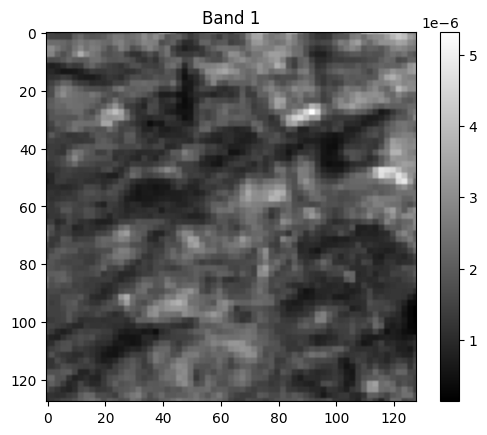

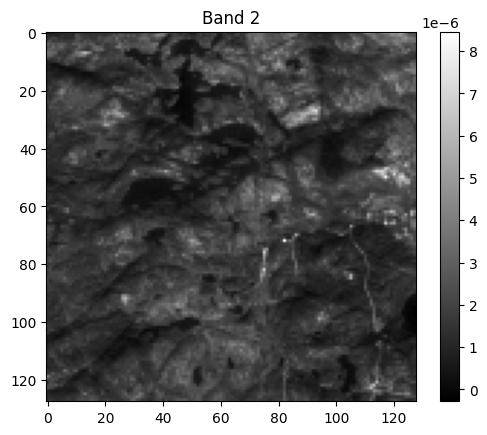

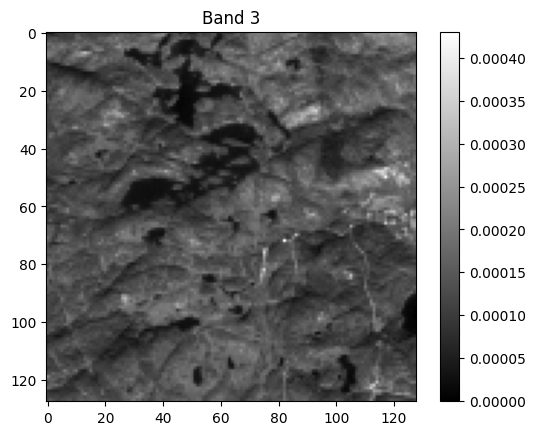

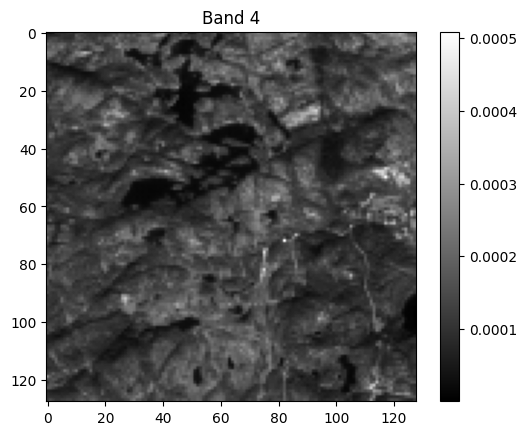

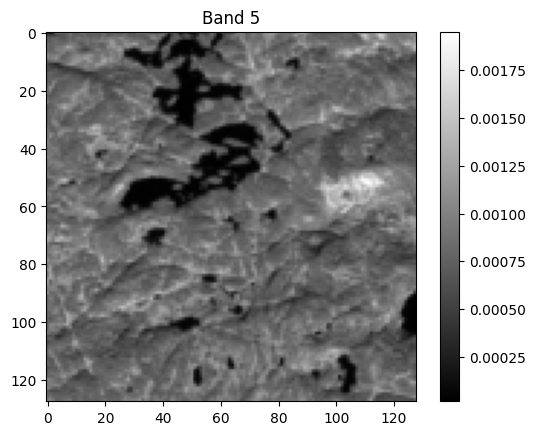

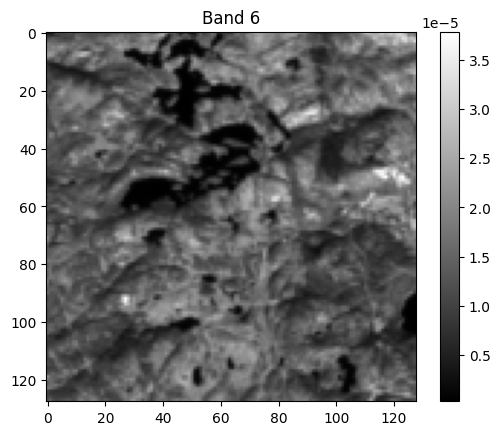

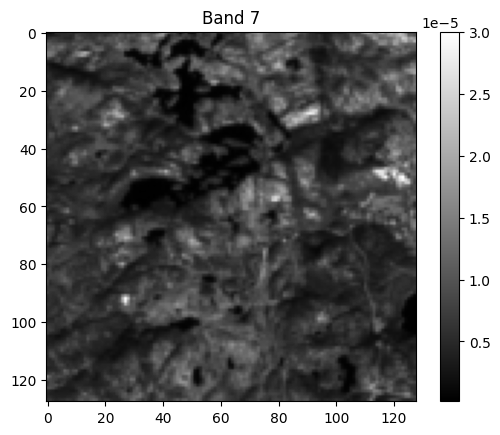

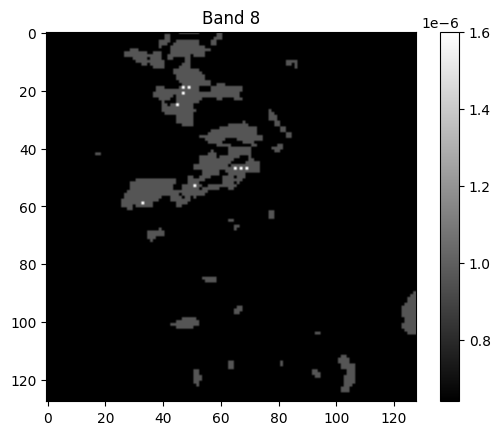

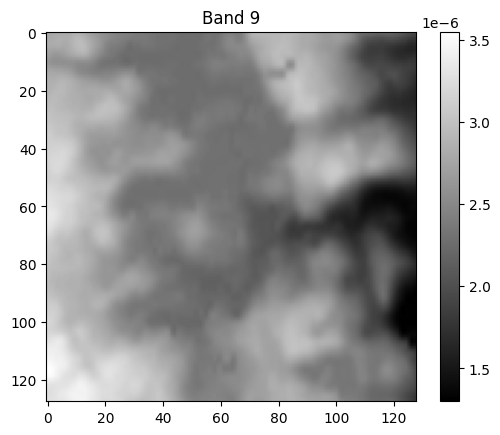

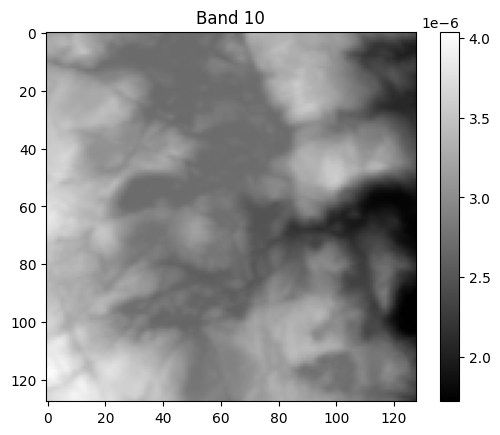

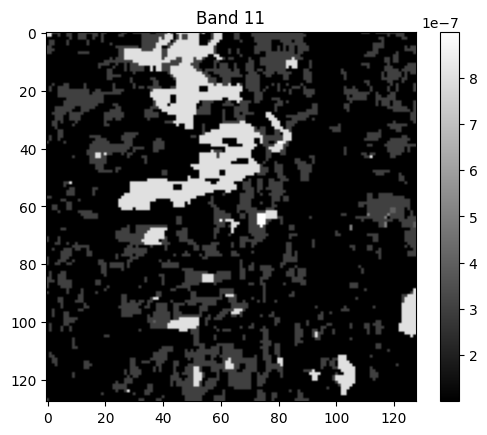

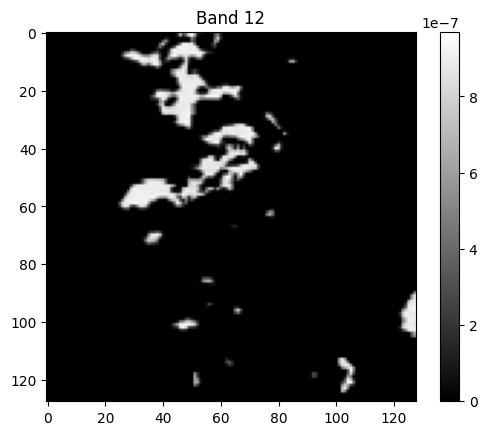

In [23]:
for i in range(IMG_CHANNELS):
    plt.figure()
    plt.title(f"Band {i+1}")
    plt.imshow(X[0, :, :, i], cmap='gray')
    plt.colorbar()
    plt.show()

## Model

#### Train-Validation Split

In [68]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

#### U-Net Model Definition

In [9]:
def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

#### Compile the Model

In [10]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,488 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,762,689 (29.61 MB)

 Trainable params: 7,762,689 (29.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Callbacks

In [11]:
checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#### Model Training

In [12]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


c:\Users\Test\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7262 - loss: 0.5806

16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7265 - loss: 0.5772 - val_accuracy: 0.7756 - val_loss: 0.3777
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8145 - loss: 0.3788

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8158 - loss: 0.3795 - val_accuracy: 0.8999 - val_loss: 0.3119
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8857 - loss: 0.3452

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8861 - loss: 0.3433 - val_accuracy: 0.9112 - val_loss: 0.2622
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8979 - loss: 0.2964

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8981 - loss: 0.2959 - val_accuracy: 0.9143 - val_loss: 0.2532
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9018 - loss: 0.2799

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9019 - loss: 0.2796 - val_accuracy: 0.9142 - val_loss: 0.2429
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8957 - loss: 0.2835 - val_accuracy: 0.9147 - val_loss: 0.2450
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9016 - loss: 0.2747

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9018 - loss: 0.2744 - val_accuracy: 0.9156 - val_loss: 0.2377
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9127 - loss: 0.2548

16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9123 - loss: 0.2552 - val_accuracy: 0.9128 - val_loss: 0.2300
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9129 - loss: 0.2489 - val_accuracy: 0.9147 - val_loss: 0.2309
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9076 - loss: 0.2576

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9075 - loss: 0.2576 - val_accuracy: 0.9125 - val_loss: 0.2287
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9177 - loss: 0.2336

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9171 - loss: 0.2349 - val_accuracy: 0.9141 - val_loss: 0.2269
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9086 - loss: 0.2541

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9085 - loss: 0.2542 - val_accuracy: 0.9167 - val_loss: 0.2239
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9069 - loss: 0.2521

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9069 - loss: 0.2520 - val_accuracy: 0.9161 - val_loss: 0.2175
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9034 - loss: 0.2548 - val_accuracy: 0.9182 - val_loss: 0.2275
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9117 - loss: 0.2427

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9114 - loss: 0.2431 - val_accuracy: 0.9184 - val_loss: 0.2130
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9049 - loss: 0.2530

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9051 - loss: 0.2523 - val_accuracy: 0.9183 - val_loss: 0.2099
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9114 - loss: 0.2354 - val_accuracy: 0.9189 - val_loss: 0.2128
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9054 - loss: 0.2509 - val_accuracy: 0.9162 - val_loss: 0.2145
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9111 - loss: 0.2397 - val_accuracy: 0.9143 - val_loss: 0.2198
Epoch 20/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9066 - loss: 0.2493 - val_accuracy: 0.9198 - val_loss: 0.2124
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9122 - loss: 0.2382

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9120 - loss: 0.2381 - val_accuracy: 0.9153 - val_loss: 0.2089
Epoch 22/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9009 - loss: 0.2447 - val_accuracy: 0.9172 - val_loss: 0.2098
Epoch 23/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9186 - loss: 0.2194

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9181 - loss: 0.2204 - val_accuracy: 0.9199 - val_loss: 0.2049
Epoch 24/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9105 - loss: 0.2413 - val_accuracy: 0.9200 - val_loss: 0.2100
Epoch 25/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9202 - loss: 0.2091

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9195 - loss: 0.2104 - val_accuracy: 0.9205 - val_loss: 0.2044
Epoch 26/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9130 - loss: 0.2336 - val_accuracy: 0.9152 - val_loss: 0.2117
Epoch 27/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9061 - loss: 0.2411 - val_accuracy: 0.9188 - val_loss: 0.2044
Epoch 28/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9041 - loss: 0.2437

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9046 - loss: 0.2429 - val_accuracy: 0.9210 - val_loss: 0.2024
Epoch 29/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9163 - loss: 0.2208

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9161 - loss: 0.2212 - val_accuracy: 0.9213 - val_loss: 0.2000
Epoch 30/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9153 - loss: 0.2191

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9151 - loss: 0.2194 - val_accuracy: 0.9201 - val_loss: 0.1961
Epoch 31/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9198 - loss: 0.2078

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9194 - loss: 0.2087 - val_accuracy: 0.9214 - val_loss: 0.1936
Epoch 32/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9088 - loss: 0.2318 - val_accuracy: 0.9208 - val_loss: 0.1969
Epoch 33/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9209 - loss: 0.2031 - val_accuracy: 0.9212 - val_loss: 0.1970
Epoch 34/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9153 - loss: 0.2152 - val_accuracy: 0.9178 - val_loss: 0.1998
Epoch 35/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9062 - loss: 0.2361 - val_accuracy: 0.9203 - val_loss: 0.1986
Epoch 36/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9064 - loss: 0.2370 - val_accuracy: 0.9173 - val_loss: 0.2009
Epoch 37/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9189 - loss: 0.2074 - val_accuracy: 0.9200 - val_loss: 0.1995
Epoch 38/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9189 - loss: 0.2107 - val_accuracy: 0.9212 - val_loss: 0.1

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9108 - loss: 0.2286 - val_accuracy: 0.9223 - val_loss: 0.1898
Epoch 42/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9175 - loss: 0.2068 - val_accuracy: 0.9224 - val_loss: 0.1905
Epoch 43/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9164 - loss: 0.2066 - val_accuracy: 0.9214 - val_loss: 0.1902
Epoch 44/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9072 - loss: 0.2223

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9075 - loss: 0.2219 - val_accuracy: 0.9213 - val_loss: 0.1885
Epoch 45/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9162 - loss: 0.2191 - val_accuracy: 0.9181 - val_loss: 0.1945
Epoch 46/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9141 - loss: 0.2166 - val_accuracy: 0.9230 - val_loss: 0.1888
Epoch 47/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9220 - loss: 0.2009 - val_accuracy: 0.9201 - val_loss: 0.1902
Epoch 48/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9216 - loss: 0.1970 - val_accuracy: 0.9091 - val_loss: 0.2351
Epoch 49/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9099 - loss: 0.2485 - val_accuracy: 0.9172 - val_loss: 0.2002
Epoch 50/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9070 - loss: 0.2294 - val_accuracy: 0.9218 - val_loss: 0.1982


#### Evaluation Metrics

In [13]:
def evaluate_model(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = (y_pred.flatten() > 0.5).astype(np.uint8)

    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)
    iou = jaccard_score(y_true_flat, y_pred_flat)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"IoU: {iou:.4f}")


#### Predict and Evaluate

In [14]:

y_pred = model.predict(X_val)
evaluate_model(Y_val, y_pred)

c:\Users\Test\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 128, 128, 12))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Precision: 0.9382
Recall: 0.6949
F1-Score: 0.7984
IoU: 0.6645


#### Visualization of Training Results

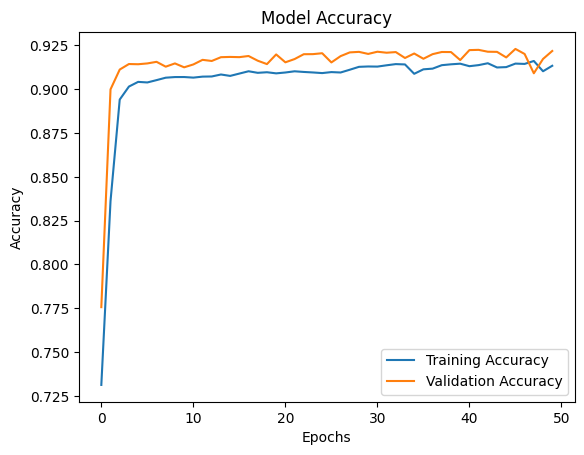

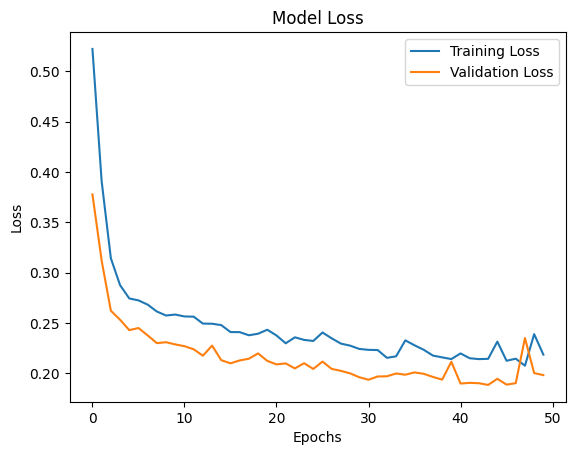

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Visualization of Predictions

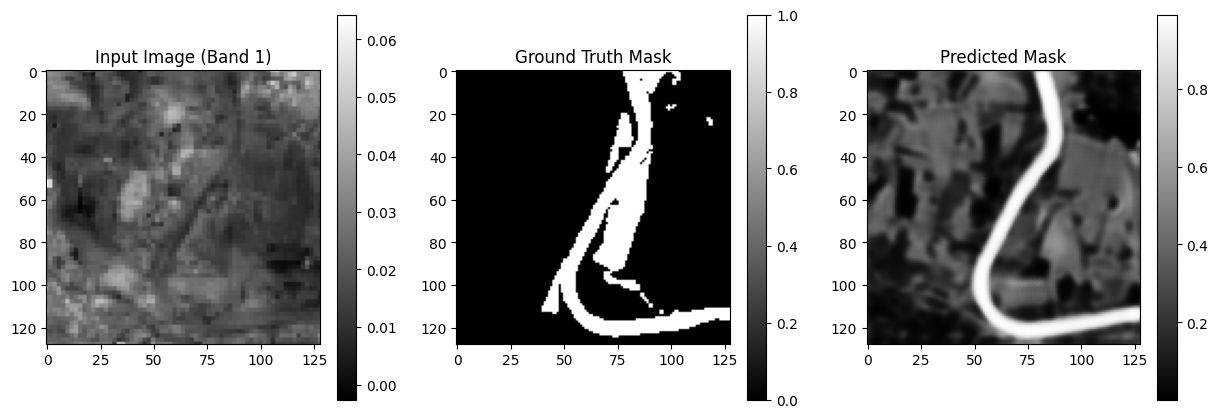

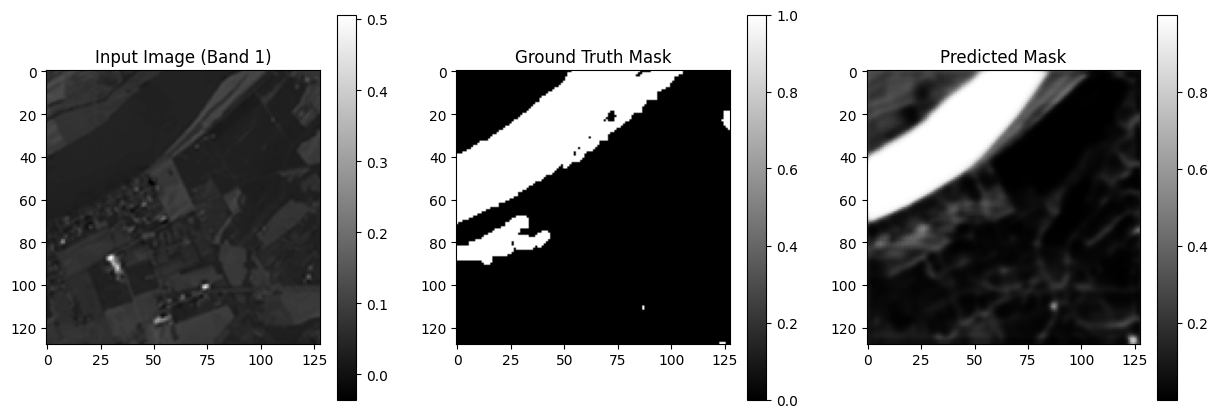

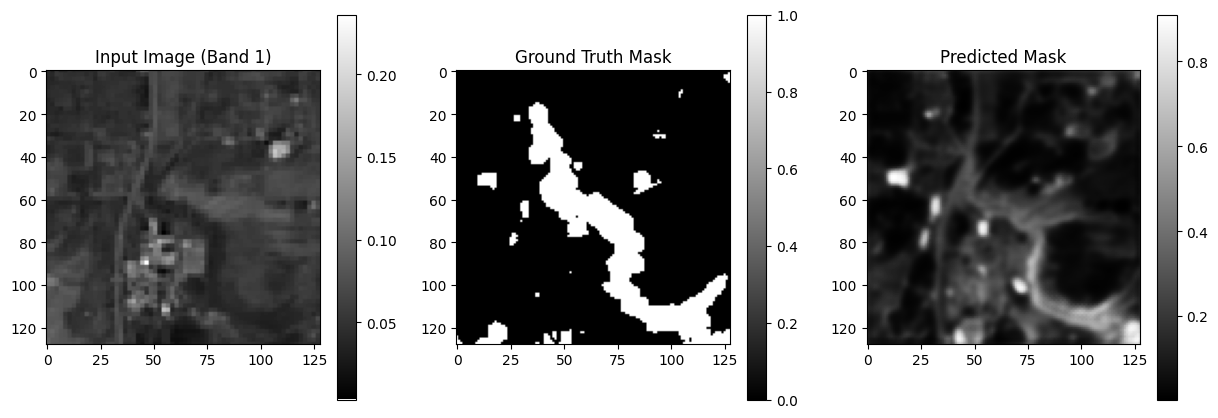

In [16]:
num_visualizations = 3
for i in range(num_visualizations):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Input Image (Band 1)')
    plt.imshow(X_val[i, :, :, 0], cmap='gray')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(Y_val[i, :, :, 0], cmap='gray')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(y_pred[i, :, :, 0], cmap='gray')
    plt.colorbar()

    plt.show()


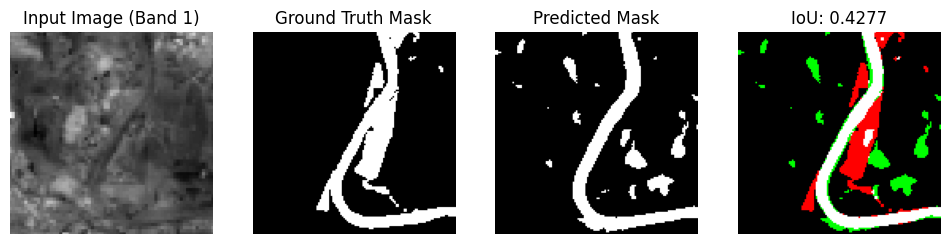

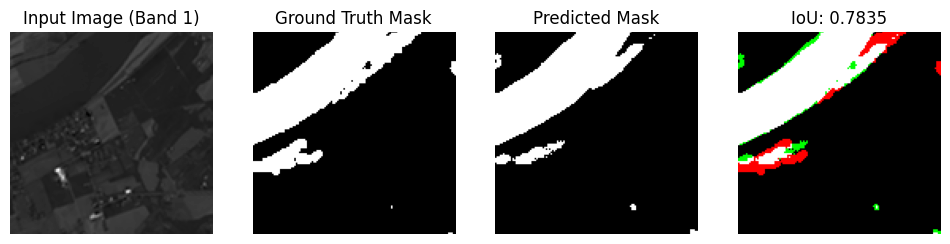

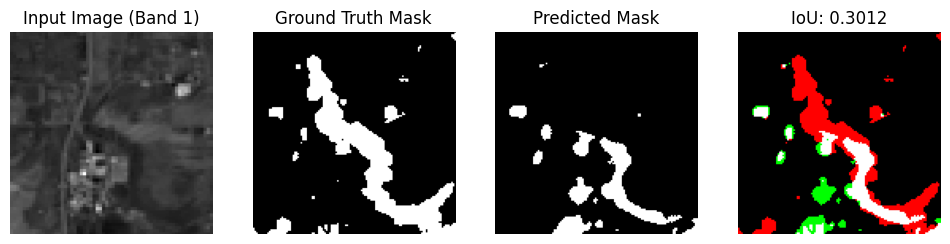

In [18]:
# Function to compute and visualize IoU
def visualize_iou(y_true, y_pred, num_samples=3):
    y_pred = (y_pred > 0.5).astype(np.uint8)  # Convert predictions to binary mask

    for i in range(num_samples):
        gt_mask = y_true[i, :, :, 0]  # Ground Truth
        pred_mask = y_pred[i, :, :, 0]  # Predicted Mask

        # Compute IoU
        intersection = np.logical_and(gt_mask, pred_mask)
        union = np.logical_or(gt_mask, pred_mask)
        iou_score = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0

        # Create overlay visualization
        overlay = np.zeros((128, 128, 3))  # RGB Image
        overlay[:, :, 0] = gt_mask  # Ground Truth (Red)
        overlay[:, :, 1] = pred_mask  # Prediction (Green)
        overlay[:, :, 2] = intersection  # TP (Blue)

        # Plot results
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 4, 1)
        plt.title("Input Image (Band 1)")
        plt.imshow(X_val[i, :, :, 0], cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(gt_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title(f"IoU: {iou_score:.4f}")
        plt.imshow(overlay)
        plt.axis('off')

        plt.show()

# Run visualization
visualize_iou(Y_val, y_pred)

## Transfare Learning 

#### Transfer Learning with Pretrained Models

In [69]:
models_list = [
    "nvidia/segformer-b1-finetuned-ade-512-512", 
    "facebook/detr-resnet-50-panoptic"
]

#### Dataset and DataLoader class

In [70]:
class WaterSegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).squeeze(-1).unsqueeze(0)
        return image, mask

#### Creating Dataset and DataLoader

In [71]:
train_dataset = WaterSegmentationDataset(X_train, Y_train)
val_dataset = WaterSegmentationDataset(X_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


#### Define Two Different Models

In [72]:
model1 = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=12, classes=1)
model2 = smp.DeepLabV3(encoder_name="resnet50", encoder_weights="imagenet", in_channels=12, classes=1)


#### Device Setup

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
model2.to(device)

DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


#### Loss and Optimizer

In [74]:
criterion = nn.BCEWithLogitsLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)


#### Training Function

In [75]:
def train_model(model, optimizer, train_loader, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
    return model

#### Train Models

In [76]:
print("Training Model 1 (Unet)...")
model1 = train_model(model1, optimizer1, train_loader, num_epochs=EPOCHS)
print("Training Model 2 (DeepLabV3)...")
model2 = train_model(model2, optimizer2, train_loader, num_epochs=EPOCHS)


Training Model 1 (Unet)...
Epoch 1/50, Loss: 0.4590
Epoch 2/50, Loss: 0.1418
Epoch 3/50, Loss: 0.2727
Epoch 4/50, Loss: 0.2405
Epoch 5/50, Loss: 0.3218
Epoch 6/50, Loss: 0.3313
Epoch 7/50, Loss: 0.4045
Epoch 8/50, Loss: 0.2147
Epoch 9/50, Loss: 0.2047
Epoch 10/50, Loss: 0.4197
Epoch 11/50, Loss: 0.2765
Epoch 12/50, Loss: 0.3580
Epoch 13/50, Loss: 0.3853
Epoch 14/50, Loss: 0.5170
Epoch 15/50, Loss: 0.1980
Epoch 16/50, Loss: 0.2241
Epoch 17/50, Loss: 0.3195
Epoch 18/50, Loss: 0.2941
Epoch 19/50, Loss: 0.2259
Epoch 20/50, Loss: 0.2476
Epoch 21/50, Loss: 0.1654
Epoch 22/50, Loss: 0.1476
Epoch 23/50, Loss: 0.2223
Epoch 24/50, Loss: 0.8360
Epoch 25/50, Loss: 0.3816
Epoch 26/50, Loss: 0.1480
Epoch 27/50, Loss: 0.4737
Epoch 28/50, Loss: 0.1913
Epoch 29/50, Loss: 0.1299
Epoch 30/50, Loss: 0.4597
Epoch 31/50, Loss: 0.1990
Epoch 32/50, Loss: 0.2274
Epoch 33/50, Loss: 0.2710
Epoch 34/50, Loss: 0.2920
Epoch 35/50, Loss: 0.6071
Epoch 36/50, Loss: 0.5650
Epoch 37/50, Loss: 0.2833
Epoch 38/50, Loss: 0

#### Evaluation Function

In [77]:
def evaluate_model(model, val_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            y_true.extend(masks.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy().flatten())
    iou = jaccard_score(y_true, y_pred, average='binary')
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    print(f"IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


#### Evaluate Models

In [78]:
evaluate_model(model1, val_loader)
evaluate_model(model2, val_loader)

IoU: 0.6708, Precision: 0.9500, Recall: 0.6954, F1-Score: 0.8030
IoU: 0.8138, Precision: 0.9247, Recall: 0.8715, F1-Score: 0.8973


#### Save Models

In [79]:
torch.save(model1.state_dict(), 'unet_water_segmentation.pth')
torch.save(model2.state_dict(), 'deeplabv3_water_segmentation.pth')
print("Models saved successfully!")


Models saved successfully!


#### Visualization

Visualizing Model 1 Predictions...


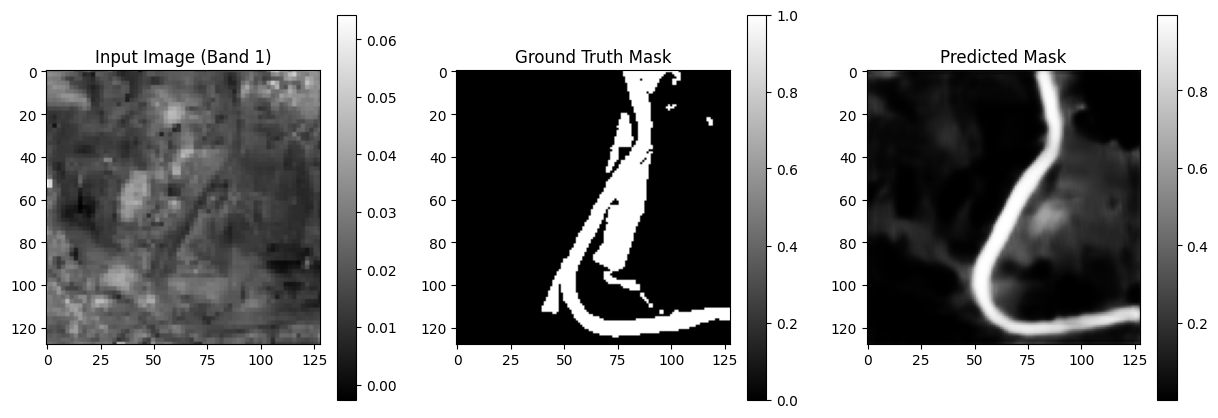

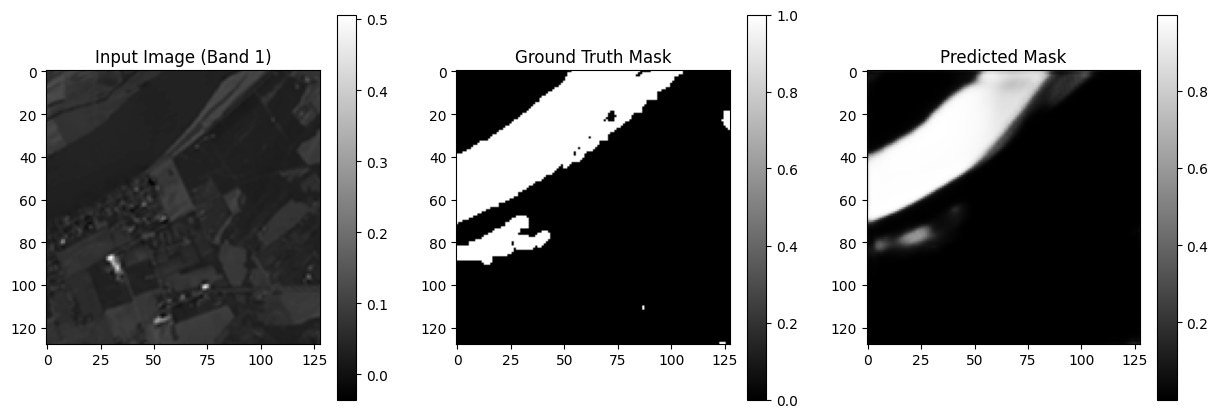

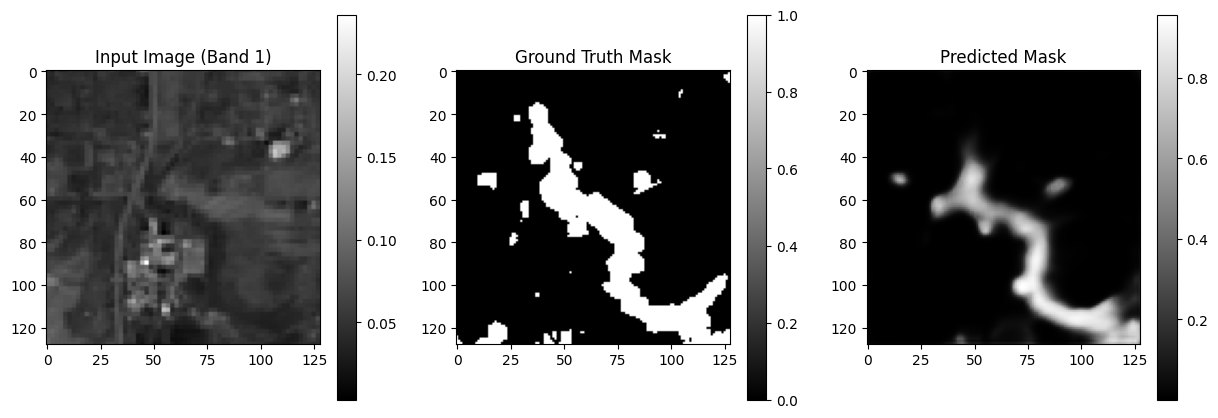

Visualizing Model 2 Predictions...


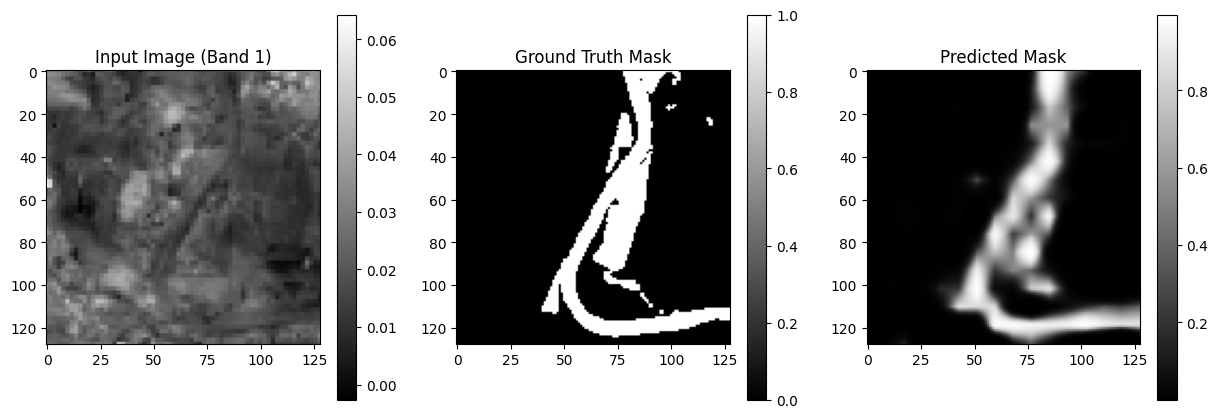

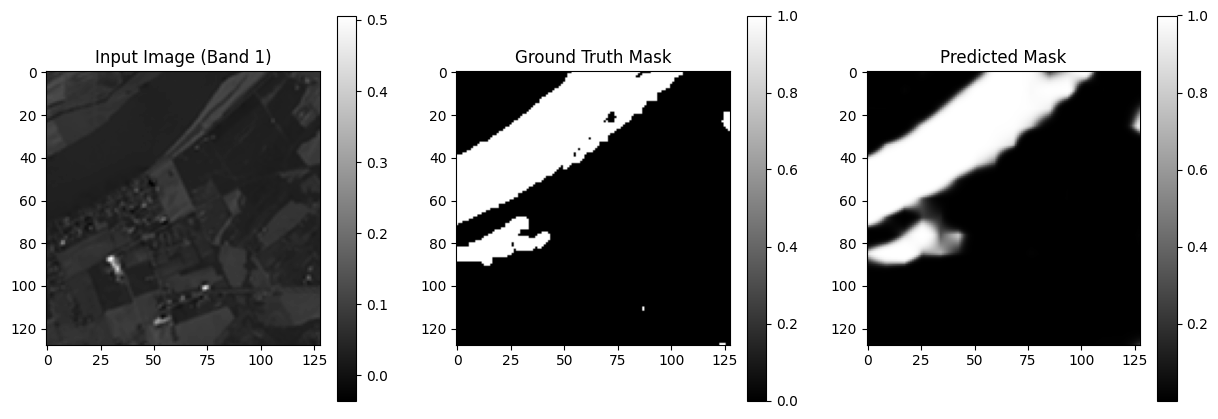

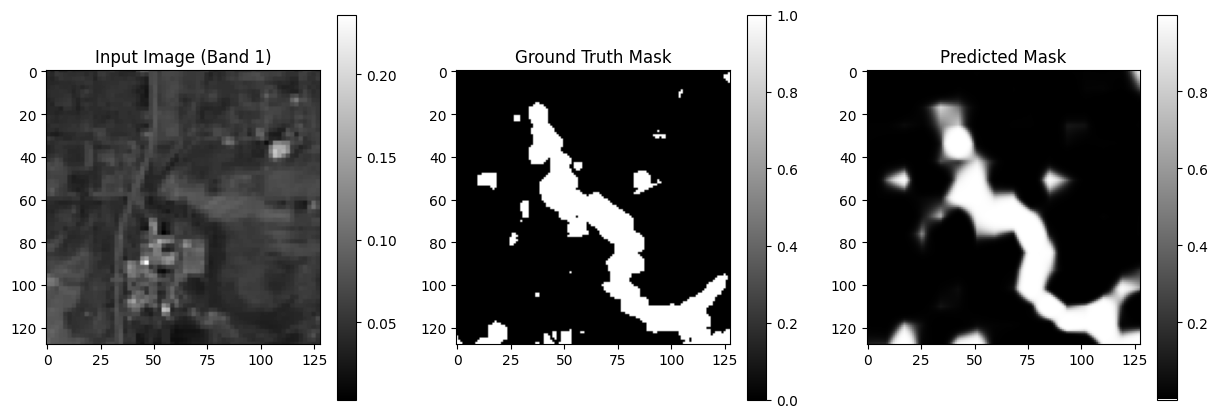

In [87]:
def visualize_predictions(model, X_val, Y_val, num_visualizations=3):
    model.eval()
    with torch.no_grad():
        preds = torch.sigmoid(model(torch.tensor(X_val[:num_visualizations], dtype=torch.float32).permute(0, 3, 1, 2).to(device))).cpu().numpy()
    
    for i in range(num_visualizations):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Input Image (Band 1)')
        plt.imshow(X_val[i, :, :, 0], cmap='gray')
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask')
        plt.imshow(Y_val[i, :, :, 0], cmap='gray')
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(preds[i, 0, :, :], cmap='gray')
        plt.colorbar()

        plt.show()

# Visualize Results
print("Visualizing Model 1 Predictions...")
visualize_predictions(model1, X_val, Y_val)
print("Visualizing Model 2 Predictions...")
visualize_predictions(model2, X_val, Y_val)

# r

In [41]:
import os
import numpy as np
import cv2  # OpenCV for reading images
import imageio
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation, DetrForSegmentation
import torch

# Objective: Week 3 Water Segmentation using Multispectral and Optical Data
# This script aims to segment water bodies accurately using multispectral and optical data.

# Directory Paths
IMAGE_DIR = r'C:\Users\Test\Downloads\data-20250216T204641Z-001\data\images'  # Folder containing input images
LABEL_DIR = r'C:\Users\Test\Downloads\data-20250216T204641Z-001\data\labels'  # Folder containing binary masks

# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 12  # 12 Channels as per the provided image
BATCH_SIZE = 16
EPOCHS = 50

# Function to Load and Preprocess Data
def load_data(image_dir, label_dir):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        base_name = filename.split('.')[0]
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, base_name + '.png')

        if not os.path.exists(label_path):
            print(f"Warning: Label file not found for {label_path}. Skipping.")
            continue

        try:
            image = imageio.imread(image_path)
        except Exception as e:
            print(f"Warning: Failed to load image {image_path}. Error: {e}. Skipping.")
            continue

        try:
            label = imageio.imread(label_path)
        except Exception as e:
            print(f"Warning: Failed to load label {label_path}. Error: {e}. Skipping.")
            continue

        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        label = cv2.resize(label, (IMG_WIDTH, IMG_HEIGHT))

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

# Loading Data
X, Y = load_data(IMAGE_DIR, LABEL_DIR)
Y = np.expand_dims(Y, axis=-1)  # Adding channel dimension to labels

# Normalization
X = X.astype(np.float32)  # Ensure consistency in data type
X /= 10000.0  # Normalize all spectral bands

# Train-Validation Split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Transfer Learning with Pretrained Models
models_list = [
    "nvidia/segformer-b1-finetuned-ade-512-512", 
    "facebook/detr-resnet-50-panoptic"
]

for model_name in models_list:
    print(f"Applying Transfer Learning Model: {model_name}")
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
    
    if "segformer" in model_name:
        pretrained_model = SegformerForSemanticSegmentation.from_pretrained(model_name)
        pretrained_model.decode_head.classifier = torch.nn.Conv2d(pretrained_model.decode_head.classifier.in_channels, 1, kernel_size=1)
        pretrained_model.model.patch_embed.proj = torch.nn.Conv2d(12, pretrained_model.model.patch_embed.proj.out_channels, kernel_size=7, stride=4, padding=3, bias=False)
    elif "detr" in model_name:
        pretrained_model = DetrForSegmentation.from_pretrained(model_name)
        pretrained_model.model.backbone.conv1 = torch.nn.Conv2d(12, pretrained_model.model.backbone.conv1.out_channels, kernel_size=7, stride=2, padding=3, bias=False)
    else:
        raise ValueError(f"Unsupported model type: {model_name}")
    
    inputs = torch.tensor(X_val[:5]).permute(0, 3, 1, 2).to(pretrained_model.device)
    
    with torch.no_grad():
        outputs = pretrained_model(inputs).logits
    
    # Extract predictions
    logits = outputs.cpu().numpy()
    predicted_masks = (logits > 0.5).astype(np.uint8)
    
    # Evaluating Transfer Learning Models
    iou_score = jaccard_score(Y_val[:5].flatten(), predicted_masks.flatten(), average='binary')
    precision = precision_score(Y_val[:5].flatten(), predicted_masks.flatten(), average='binary')
    recall = recall_score(Y_val[:5].flatten(), predicted_masks.flatten(), average='binary')
    f1 = f1_score(Y_val[:5].flatten(), predicted_masks.flatten(), average='binary')
    
    print(f"Model: {model_name} - IoU: {iou_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    
    # Visualizing Transfer Learning Predictions
    for i in range(5):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Ground Truth")
        plt.imshow(Y_val[i].squeeze(), cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title(f"Predicted ({model_name})")
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
        plt.show()


C:\Users\Test\AppData\Local\Temp\ipykernel_8472\1049383566.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
C:\Users\Test\AppData\Local\Temp\ipykernel_8472\1049383566.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_path)


Applying Transfer Learning Model: nvidia/segformer-b1-finetuned-ade-512-512


AttributeError: 'SegformerForSemanticSegmentation' object has no attribute 'model'

In [61]:
import os
import numpy as np
import cv2
import imageio
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn

# Directory Paths
IMAGE_DIR = r'C:\Users\Test\Downloads\data-20250216T204641Z-001\data\images'
LABEL_DIR = r'C:\Users\Test\Downloads\data-20250216T204641Z-001\data\labels'

# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 12
BATCH_SIZE = 16
EPOCHS = 50

# Function to Load and Preprocess Data
def load_data(image_dir, label_dir):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        base_name = filename.split('.')[0]
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, base_name + '.png')

        if not os.path.exists(label_path):
            print(f"Warning: Label file not found for {label_path}. Skipping.")
            continue

        try:
            image = imageio.imread(image_path)
            label = imageio.imread(label_path)
        except Exception as e:
            print(f"Warning: Failed to load {image_path} or {label_path}. Error: {e}. Skipping.")
            continue

        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        label = cv2.resize(label, (IMG_WIDTH, IMG_HEIGHT))

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

# Loading Data
X, Y = load_data(IMAGE_DIR, LABEL_DIR)
Y = np.expand_dims(Y, axis=-1)

# Normalization
X = X.astype(np.float32) / 10000.0

# Train-Validation Split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Dataset and DataLoader class
class WaterSegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).squeeze(-1).unsqueeze(0)

        return image, mask

# Creating Dataset and DataLoader
train_dataset = WaterSegmentationDataset(X_train, Y_train)
val_dataset = WaterSegmentationDataset(X_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define Two Different Models
model1 = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=12, classes=1)
model2 = smp.DeepLabV3(encoder_name="resnet50", encoder_weights="imagenet", in_channels=12, classes=1)

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
model2.to(device)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# Training Function
def train_model(model, optimizer, train_loader, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
    return model

# Train Models
print("Training Model 1 (Unet)...")
model1 = train_model(model1, optimizer1, train_loader, num_epochs=EPOCHS)
print("Training Model 2 (DeepLabV3)...")
model2 = train_model(model2, optimizer2, train_loader, num_epochs=EPOCHS)

# Evaluation Function
def evaluate_model(model, val_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            y_true.extend(masks.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy().flatten())
    iou = jaccard_score(y_true, y_pred, average='binary')
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    print(f"IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Evaluate Models
evaluate_model(model1, val_loader)
evaluate_model(model2, val_loader)

# Save Models
torch.save(model1.state_dict(), 'unet_water_segmentation.pth')
torch.save(model2.state_dict(), 'deeplabv3_water_segmentation.pth')
print("Models saved successfully!")

# Visualization
def visualize_predictions(model, val_loader):
    model.eval()
    images, masks = next(iter(val_loader))
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
    preds = torch.sigmoid(outputs).cpu().numpy()
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        axes[0, i].imshow(images[i].cpu().permute(1, 2, 0))
        axes[0, i].set_title("Original Image")
        axes[1, i].imshow(masks[i].cpu().squeeze(), cmap="gray")
        axes[1, i].set_title("Ground Truth")
        axes[2, i].imshow(preds[i].squeeze(), cmap="gray")
        axes[2, i].set_title("Predicted")
    plt.show()

# Visualize Results
print("Visualizing Model 1 Predictions...")
visualize_predictions(model1, val_loader)
print("Visualizing Model 2 Predictions...")
visualize_predictions(model2, val_loader)


C:\Users\Test\AppData\Local\Temp\ipykernel_8472\3559501439.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
C:\Users\Test\AppData\Local\Temp\ipykernel_8472\3559501439.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_path)


Training Model 1 (Unet)...
Epoch 1/50, Loss: 0.3840
Epoch 2/50, Loss: 0.4362
Epoch 3/50, Loss: 0.1852
Epoch 4/50, Loss: 0.6907
Epoch 5/50, Loss: 0.2505
Epoch 6/50, Loss: 0.1955
Epoch 7/50, Loss: 0.2652
Epoch 8/50, Loss: 0.1424
Epoch 9/50, Loss: 0.3950
Epoch 10/50, Loss: 0.2316
Epoch 11/50, Loss: 0.2676
Epoch 12/50, Loss: 0.3469
Epoch 13/50, Loss: 0.7751
Epoch 14/50, Loss: 0.4160


KeyboardInterrupt: 

In [49]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import pandas as pd
import torch
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def load_ecg_data(images_dir, masks_dir, test_size=0.2, val_size=0.1):
    images = os.listdir(images_dir)
    train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
    train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=42)
    return train_images, val_images, test_images

class ECGSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_name = img_name.replace('.tif', '.png')
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = rasterio.open(img_path).read()
        mask = np.array(Image.open(mask_path).convert("L"))
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((128, 128)),
])

images_dir =r'C:\Users\Test\Downloads\data-20250216T204641Z-001\data\images'  # Folder containing input images
masks_dir =r'C:\Users\Test\Downloads\data-20250216T204641Z-001\data\labels'  # Folder containing binary masks
train_images, val_images, test_images = load_ecg_data(images_dir, masks_dir)

train_dataset = ECGSegmentationDataset(images_dir, masks_dir, train_images, transform=transform)
val_dataset = ECGSegmentationDataset(images_dir, masks_dir, val_images, transform=transform)
test_dataset = ECGSegmentationDataset(images_dir, masks_dir, test_images, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

pre_conv = nn.Conv2d(12, 3, kernel_size=1)

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_conv.to(device)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, pre_conv, train_loader, val_loader, num_epochs=50, lr=1e-4, threshold=0.5):
    optimizer = optim.Adam(list(pre_conv.parameters()) + list(model.parameters()), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(pre_conv(inputs))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
    
    return model

model = train_model(model, pre_conv, train_loader, val_loader, num_epochs=20, threshold=0.5)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(pre_conv(inputs))
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()
    print(f"Test Accuracy: {correct / total:.4f}")

evaluate_model(model, test_loader)

torch.save({
    'pre_conv_state_dict': pre_conv.state_dict(),
    'model_state_dict': model.state_dict(),
}, 'unet_model.pth')

print("Model saved successfully!")


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Test/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:26<00:00, 3.29MB/s]
c:\Users\Test\AppData\Local\Programs\Python\Python311\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 1/20, Loss: 0.4565
Epoch 2/20, Loss: 0.2634
Epoch 3/20, Loss: 0.4471
Epoch 4/20, Loss: 0.8508
Epoch 5/20, Loss: 0.3200
Epoch 6/20, Loss: 0.6984
Epoch 7/20, Loss: 0.1537
Epoch 8/20, Loss: 0.2491
Epoch 9/20, Loss: 0.2718
Epoch 10/20, Loss: 0.1417
Epoch 11/20, Loss: 0.1739
Epoch 12/20, Loss: 0.1621
Epoch 13/20, Loss: 0.0927
Epoch 14/20, Loss: 0.1670
Epoch 15/20, Loss: 1.1223
Epoch 16/20, Loss: 0.5341
Epoch 17/20, Loss: 0.1894
Epoch 18/20, Loss: 0.3341
Epoch 19/20, Loss: 0.0884
Epoch 20/20, Loss: 0.1072
Test Accuracy: 0.9529
Model saved successfully!


#### Evaluating Transfer Learning Models

In [ ]:

    predicted_masks = np.argmax(predictions.logits.detach().numpy(), axis=1)
    iou_score = jaccard_score(Y_val[:5].flatten(), predicted_masks.flatten(), average='binary')
    precision = precision_score(Y_val[:5].flatten(), predicted_masks.flatten(), average='binary')
    recall = recall_score(Y_val[:5].flatten(), predicted_masks.flatten(), average='binary')
    f1 = f1_score(Y_val[:5].flatten(), predicted_masks.flatten(), average='binary')
    
    print(f"Model: {model_name} - IoU: {iou_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    

#### Visualizing Transfer Learning Predictions

In [ ]:
for i in range(5):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Ground Truth")
        plt.imshow(Y_val[i].squeeze(), cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title(f"Predicted ({model_name})")
        plt.imshow(predictions.logits[i].detach().numpy().squeeze(), cmap='gray')
        plt.show()
